### new pipeline without cell cycle regression

In [1]:
library(Signac)
library(Seurat)
library(EnsDb.Hsapiens.v86)
library(BSgenome.Hsapiens.UCSC.hg38)
library(pals)
library(scater) #quality control and visualization for scRNA-seq data
library(scran) #for low level processing of scRNA-seq data
library(DropletUtils)
library(tensorflow)
library(SingleR) #automated cell type annotation ('label transfer') using reference data
library(celldex) #a large collection of reference expression datasets with curated cell type labels for use with SingleR package
library(pheatmap)
library(ggplot2)
library(dplyr)
library(GenomeInfoDb)
library(patchwork)
library(chromVAR)
library(motifmatchr)
library(Matrix)
library(SummarizedExperiment)
library(BiocParallel)
library(JASPAR2020)
library(TFBSTools)
library(tidyverse)
library(Pando)

set.seed(1234)

Attaching SeuratObject

Loading required package: ensembldb

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb

Loading requir

In [2]:
T_cells_noCC <- readRDS(file = "/corgi/martin/multiome_T/RDS_final/T_cells_noCC_DICE_ATAC_final_peaks to genes.RDS")
T_cells_noCC

An object of class Seurat 
412523 features across 7069 samples within 5 assays 
Active assay: peaks.DICE (94182 features, 94100 variable features)
 4 other assays present: RNA, ATAC, peaks, SCT
 5 dimensional reductions calculated: pca, umap_RNA, lsi, umap_ATAC, umap_joint

In [3]:
Idents(T_cells_noCC) <- "SingleR.labels"

T_cells_naive <- subset(x = T_cells_noCC, idents = "T cells, CD4+, naive")
T_cells_naive.stim <- subset(x = T_cells_noCC, idents = "T cells, CD4+, naive, stimulated")
T_cells_Th1 <- subset(x = T_cells_noCC, idents = "T cells, CD4+, Th1")
T_cells_Th2 <- subset(x = T_cells_noCC, idents = "T cells, CD4+, Th2")
T_cells_NK <- subset(x = T_cells_noCC, idents = "NK cells")
T_cells_Th17 <- subset(x = T_cells_noCC, idents = "T cells, CD4+, Th17")
T_cells_Th1_17 <- subset(x = T_cells_noCC, idents = "T cells, CD4+, Th1_17")
T_cells_TREG.naive <- subset(x = T_cells_noCC, idents = "T cells, CD4+, naive TREG")
T_cells_TREG.mem <- subset(x = T_cells_noCC, idents = "T cells, CD4+, memory TREG")

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from umap_atac_ to umapatac_"
Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from umap_joint_ to umapjoint_"
Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from umap_atac_ to umapatac_"
Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from umap_joint_ to umapjoint_"
Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from umap_atac_ to umapatac_"
Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from umap_joint_ to umapjoint_"
Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from umap_atac_ to umapatac_"
Warning message:
"Keys shoul

In [4]:
T_cells_Th1_17

An object of class Seurat 
412523 features across 307 samples within 5 assays 
Active assay: peaks.DICE (94182 features, 94100 variable features)
 4 other assays present: RNA, ATAC, peaks, SCT
 5 dimensional reductions calculated: pca, umap_RNA, lsi, umap_ATAC, umap_joint

In [5]:
T_cells_naive <- initiate_grn(T_cells_naive, rna_assay = 'SCT', peak_assay = 'peaks.DICE')
T_cells_naive.stim <- initiate_grn(T_cells_naive.stim, rna_assay = 'SCT', peak_assay = 'peaks.DICE')
T_cells_Th1 <- initiate_grn(T_cells_Th1, rna_assay = 'SCT', peak_assay = 'peaks.DICE')
T_cells_Th2 <- initiate_grn(T_cells_Th2, rna_assay = 'SCT', peak_assay = 'peaks.DICE')
T_cells_NK <- initiate_grn(T_cells_NK, rna_assay = 'SCT', peak_assay = 'peaks.DICE')
T_cells_Th17 <- initiate_grn(T_cells_Th17, rna_assay = 'SCT', peak_assay = 'peaks.DICE')
T_cells_Th1_17 <- initiate_grn(T_cells_Th1_17, rna_assay = 'SCT', peak_assay = 'peaks.DICE')
T_cells_TREG.naive <- initiate_grn(T_cells_TREG.naive, rna_assay = 'SCT', peak_assay = 'peaks.DICE')
T_cells_TREG.mem <- initiate_grn(T_cells_TREG.mem, rna_assay = 'SCT', peak_assay = 'peaks.DICE')

In [6]:
T_cells_Th1_17

An object of class SeuratPlus 
412523 features across 307 samples within 5 assays 
Active assay: peaks.DICE (94182 features, 94100 variable features)
 4 other assays present: RNA, ATAC, peaks, SCT
 5 dimensional reductions calculated: pca, umap_RNA, lsi, umap_ATAC, umap_joint

In [7]:
# Get a list of motif position frequency matrices from the JASPAR database
pfm <- getMatrixSet(
    x = JASPAR2020,
    opts = list(collection = "CORE", tax_group = 'vertebrates', all_versions = FALSE)
)

In [8]:
library(BSgenome.Hsapiens.UCSC.hg38)

T_cells_naive <- find_motifs(T_cells_naive, pfm = pfm, genome = BSgenome.Hsapiens.UCSC.hg38)
T_cells_naive.stim <- find_motifs(T_cells_naive.stim, pfm = pfm, genome = BSgenome.Hsapiens.UCSC.hg38)
T_cells_Th1 <- find_motifs(T_cells_Th1, pfm = pfm, genome = BSgenome.Hsapiens.UCSC.hg38)
T_cells_Th2 <- find_motifs(T_cells_Th2, pfm = pfm, genome = BSgenome.Hsapiens.UCSC.hg38)
T_cells_NK <- find_motifs(T_cells_NK, pfm = pfm, genome = BSgenome.Hsapiens.UCSC.hg38)
T_cells_Th17 <- find_motifs(T_cells_Th17, pfm = pfm, genome = BSgenome.Hsapiens.UCSC.hg38)
T_cells_Th1_17 <- find_motifs(T_cells_Th1_17, pfm = pfm, genome = BSgenome.Hsapiens.UCSC.hg38)
T_cells_TREG.naive <- find_motifs(T_cells_TREG.naive, pfm = pfm, genome = BSgenome.Hsapiens.UCSC.hg38)
T_cells_TREG.mem <- find_motifs(T_cells_TREG.mem, pfm = pfm, genome = BSgenome.Hsapiens.UCSC.hg38)

Adding TF info

Building motif matrix

Finding motif positions

Creating Motif object

Adding TF info

Building motif matrix

Finding motif positions

Creating Motif object

Adding TF info

Building motif matrix

Finding motif positions

Creating Motif object

Adding TF info

Building motif matrix

Finding motif positions

Creating Motif object

Adding TF info

Building motif matrix

Finding motif positions

Creating Motif object

Adding TF info

Building motif matrix

Finding motif positions

Creating Motif object

Adding TF info

Building motif matrix

Finding motif positions

Creating Motif object

Adding TF info

Building motif matrix

Finding motif positions

Creating Motif object

Adding TF info

Building motif matrix

Finding motif positions

Creating Motif object



In [9]:
#library(doParallel)
library(grr)
#registerDoParallel(4)


Attaching package: 'grr'


The following objects are masked from 'package:tidyr':

    extract, matches


The following object is masked from 'package:dplyr':

    matches




In [11]:
T_cells_Th1 <- infer_grn(T_cells_Th1, peak_to_gene_method = 'Signac', method = 'xgb')
saveRDS(T_cells_Th1, file = "/corgi/martin/multiome_T/RDS_final/Pando_noCC/Pando_Th1.RDS")

Selecting candidate regulatory regions near genes

Preparing model input

Fitting models for 2319 target genes



In [12]:
T_cells_Th2 <- infer_grn(T_cells_Th2, peak_to_gene_method = 'Signac', method = 'xgb')
saveRDS(T_cells_Th2, file = "/corgi/martin/multiome_T/RDS_final/Pando_noCC/Pando_Th2.RDS")

Selecting candidate regulatory regions near genes

Preparing model input

Fitting models for 2319 target genes



In [13]:
T_cells_NK <- infer_grn(T_cells_NK, peak_to_gene_method = 'Signac', method = 'xgb')
saveRDS(T_cells_NK, file = "/corgi/martin/multiome_T/RDS_final/Pando_noCC/Pando_NK.RDS")

Selecting candidate regulatory regions near genes

Preparing model input

Fitting models for 2319 target genes



In [14]:
T_cells_Th17 <- infer_grn(T_cells_Th17, peak_to_gene_method = 'Signac', method = 'xgb')
saveRDS(T_cells_Th17, file = "/corgi/martin/multiome_T/RDS_final/Pando_noCC/Pando_Th17.RDS")

Selecting candidate regulatory regions near genes

Preparing model input

Fitting models for 2319 target genes



In [15]:
T_cells_Th1_17 <- infer_grn(T_cells_Th1_17, peak_to_gene_method = 'Signac', method = 'xgb')
saveRDS(T_cells_Th1_17, file = "/corgi/martin/multiome_T/RDS_final/Pando_noCC/Pando_Th1_17.RDS")

Selecting candidate regulatory regions near genes

Preparing model input

Fitting models for 2319 target genes



In [16]:
T_cells_TREG.naive <- infer_grn(T_cells_TREG.naive, peak_to_gene_method = 'Signac', method = 'xgb')
saveRDS(T_cells_TREG.naive, file = "/corgi/martin/multiome_T/RDS_final/Pando_noCC/Pando_Treg_naive.RDS")

Selecting candidate regulatory regions near genes

Preparing model input

Fitting models for 2319 target genes



In [10]:
T_cells_TREG.mem <- infer_grn(T_cells_TREG.mem, peak_to_gene_method = 'Signac', method = 'xgb')
saveRDS(T_cells_TREG.mem, file = "/corgi/martin/multiome_T/RDS_final/Pando_noCC/Pando_Treg_mem.RDS")

Selecting candidate regulatory regions near genes

Preparing model input

Fitting models for 2319 target genes



In [11]:
T_cells_naive <- infer_grn(T_cells_naive, peak_to_gene_method = 'Signac', method = 'xgb')
saveRDS(T_cells_naive, file = "/corgi/martin/multiome_T/RDS_final/Pando_noCC/Pando_naive.RDS")

Selecting candidate regulatory regions near genes

Preparing model input

Fitting models for 2319 target genes



In [12]:
T_cells_naive.stim <- infer_grn(T_cells_naive.stim, peak_to_gene_method = 'Signac', method = 'xgb')
saveRDS(T_cells_naive.stim, file = "/corgi/martin/multiome_T/RDS_final/Pando_noCC/Pando_naive_stim.RDS")

Selecting candidate regulatory regions near genes

Preparing model input

Fitting models for 2319 target genes



In [13]:
GetNetwork(T_cells_Th1_17)

A Network object
with 740 TFs and 2032 target genes

In [14]:
GetNetwork(T_cells_TREG.mem)

A Network object
with 751 TFs and 2046 target genes

In [4]:
#T_cells_naive <- readRDS(file = "/corgi/martin/multiome_T/RDS_final/Pando_naive.RDS")
#T_cells_naive.stim <- readRDS(file = "/corgi/martin/multiome_T/RDS_final/Pando_naive_stim.RDS")
#T_cells_Th1 <- readRDS(file = "/corgi/martin/multiome_T/RDS_final/Pando_Th1.RDS")
#T_cells_Th2 <- readRDS(file = "/corgi/martin/multiome_T/RDS_final/Pando_Th2.RDS")
#T_cells_NK <- readRDS(file = "/corgi/martin/multiome_T/RDS_final/Pando_NK.RDS")
#T_cells_Th17 <- readRDS(file = "/corgi/martin/multiome_T/RDS_final/Pando_Th17.RDS")

In [5]:
# quick overview of dataframe coefficients (estimate) and p-values (pval) for each TF/region-target gene pair
#coef(T_cells_naive)

In [69]:
#top10_Tnaive <- top_n(data_Tnaive, 10, gain)

Tnaive <- data.frame(coef(T_cells_naive))
Th1 <- data.frame(coef(T_cells_Th1))

In [71]:
Th1

tf,target,region,term,gain,cover,frequency,corr
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
HMGB1,CSF2RA,chrX-1207940-1208757,HMGB1:chrX_1207940_1208757,0.1127023773,9.423339e-02,0.0879750130,0.1114839
TRPS1,CSF2RA,chrX-1242718-1243366,TRPS1:chrX_1242718_1243366,0.0989750497,9.108947e-02,0.0858927642,0.1448895
YBX1,CSF2RA,chrX-1224830-1225292,YBX1:chrX_1224830_1225292,0.0948790235,8.173559e-02,0.0780843311,0.1266520
FOSL2,CSF2RA,chrX-1212751-1212919,FOSL2:chrX_1212751_1212919,0.0794989083,7.980552e-02,0.0749609578,0.1401711
ELF1,CSF2RA,chrX-1174914-1175514,chrX_1174914_1175514:ELF1,0.0686965298,6.366180e-02,0.0588235294,-0.1028582
ZNF721,CSF2RA,chrX-1212455-1212555,ZNF721:chrX_1212455_1212555,0.0655151266,6.149372e-02,0.0572618428,0.1276402
ETV6,CSF2RA,chrX-1207940-1208757,chrX_1207940_1208757:ETV6,0.0637226551,5.881067e-02,0.0541384695,0.1393864
TRERF1,CSF2RA,chrX-1249163-1249818,TRERF1:chrX_1249163_1249818,0.0622418714,6.032530e-02,0.0551795940,0.1060060
TRPS1,CSF2RA,chrX-1205519-1206418,TRPS1:chrX_1205519_1206418,0.0615454395,6.159542e-02,0.0676730869,0.1448895


In [70]:
Tnaive

tf,target,region,term,gain,cover,frequency,corr
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
KLF2,CSF2RA,chrX-1207940-1208757,KLF2:chrX_1207940_1208757,8.331739e-01,0.698144313,0.69811321,0.2234628
KLF2,CSF2RA,chrX-1176434-1177249,chrX_1176434_1177249:KLF2,1.668261e-01,0.301855687,0.30188679,0.2234628
VDR,DHRSX,chrX-2500101-2500310,chrX_2500101_2500310:VDR,6.026801e-01,0.475530089,0.52639805,0.1057360
PBX4,DHRSX,chrX-2500101-2500310,chrX_2500101_2500310:PBX4,3.973199e-01,0.524469911,0.47360195,0.1018028
GLIS2,FAM9B,chrX-9165737-9166243,GLIS2:chrX_9165737_9166243,1.000000e+00,1.000000000,1.00000000,0.1124504
BHLHE40,TBL1X,chrX-9677043-9677729,chrX_9677043_9677729:BHLHE40,1.000000e+00,1.000000000,1.00000000,-0.1157358
NFIX,ARHGAP6,chrX-11759179-11759551,NFIX:chrX_11759179_11759551,5.190789e-01,0.413424002,0.30486712,0.1082491
MEF2B,ARHGAP6,chrX-11757719-11758158,MEF2B:chrX_11757719_11758158,4.808957e-01,0.444200447,0.58972828,0.1451281
NFIX,ARHGAP6,chrX-11111142-11111300,chrX_11111142_11111300:NFIX,1.139012e-05,0.057270678,0.04240072,0.1082491


In [73]:
Tnaive_cutoff <- Tnaive[Tnaive$gain == 1,]
Tnaive_cutoff

,tf,target,region,term,gain,cover,frequency,corr
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
5,GLIS2,FAM9B,chrX-9165737-9166243,GLIS2:chrX_9165737_9166243,1,1,1,0.1124504
6,BHLHE40,TBL1X,chrX-9677043-9677729,chrX_9677043_9677729:BHLHE40,1,1,1,-0.1157358
46,MAF,NHS,chrX-17632966-17633274,chrX_17632966_17633274:MAF,1,1,1,0.1102353
47,SMARCA1,MAP7D2,chrX-19990282-19991397,chrX_19990282_19991397:SMARCA1,1,1,1,0.1005969
48,ZNF367,POLA1,chrX-24693337-24693918,chrX_24693337_24693918:ZNF367,1,1,1,0.1235390
67,HIF3A,MIR222HG,chrX-45850313-45851353,HIF3A:chrX_45850313_45851353,1,1,1,0.1552507
117,ZNF470,BTK,chrX-101429898-101430786,ZNF470:chrX_101429898_101430786,1,1,1,0.1191809
123,FOSL2,GPC3,chrX-134013000-134013373,chrX_134013000_134013373:FOSL2,1,1,1,0.1042150
124,TOX,AFF2,chrX-148738438-148738673,chrX_148738438_148738673:TOX,1,1,1,0.1147498


In [74]:
Th1_cutoff <- Th1[Th1$gain == 1,]
Th1_cutoff

,tf,target,region,term,gain,cover,frequency,corr
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
141,FLI1,FRMPD4,chrX-12672377-12672873,chrX_12672377_12672873:FLI1,1,1,1,0.1574940
307,TFCP2,PTCHD1,chrX-23333243-23333759,chrX_23333243_23333759:TFCP2,1,1,1,0.1710240
700,ID2,ZC3H12B,chrX-65406413-65406807,chrX_65406413_65406807:ID2,1,1,1,-0.1622869
2682,ZNF775,DRAXIN,chr1-11681439-11681737,ZNF775:chr1_11681439_11681737,1,1,1,0.3878558
2930,MTA3,NCMAP,chr1-24555560-24555815,MTA3:chr1_24555560_24555815,1,1,1,0.1420824
6500,CEBPG,KLHDC9,chr1-161044942-161045857,CEBPG:chr1_161044942_161045857,1,1,1,0.1461611
6530,ZNF117,HSPA6,chr1-161439729-161440775,chr1_161439729_161440775:ZNF117,1,1,1,0.4043638
6531,ZNF347,FCRLB,chr1-161621167-161621914,chr1_161621167_161621914:ZNF347,1,1,1,0.4224061
7401,RUNX3,SOX13,chr1-204057520-204058064,chr1_204057520_204058064:RUNX3,1,1,1,0.1290256


In [29]:
T_cells_naive <- find_modules(T_cells_naive)
T_cells_naive_modules_xgb <- NetworkModules(T_cells_naive)

Found 332 TF modules



In [8]:
T_cells_naive.stim <- find_modules(T_cells_naive.stim)
T_cells_naive.stim_modules_xgb <- NetworkModules(T_cells_naive.stim)

Found 527 TF modules



In [53]:
T_cells_Th1 <- find_modules(T_cells_Th1, p_thresh = 0.001, nvar_thresh = 100, rsq_thresh = 0.5)
T_cells_Th1_modules_xgb <- NetworkModules(T_cells_Th1)

Found 696 TF modules



In [10]:
T_cells_Th2 <- find_modules(T_cells_Th2)
T_cells_Th2_modules_xgb <- NetworkModules(T_cells_Th2)

Found 735 TF modules



In [54]:
T_cells_NK <- find_modules(T_cells_NK, p_thresh = 0.001, nvar_thresh = 100, rsq_thresh = 0.5)
T_cells_NK_modules_xgb <- NetworkModules(T_cells_NK)

Found 609 TF modules



In [13]:
T_cells_Th17 <- find_modules(T_cells_Th17)
T_cells_Th17_modules_xgb <- NetworkModules(T_cells_Th17)

Found 711 TF modules



In [14]:
#T_cells_Th1_17 <- find_modules(T_cells_Th1_17)
#T_cells_Th1_17_modules_xgb <- NetworkModules(T_cells_Th1_17)

In [15]:
#T_cells_TREG.naive<- find_modules(T_cells_TREG.naive)
#T_cells_TREG.naive_modules_xgb <- NetworkModules(T_cells_TREG.naive)

In [16]:
#T_cells_TREG.mem <- find_modules(T_cells_TREG.mem)
#T_cells_TREG.mem_modules_xgb <- NetworkModules(T_cells_TREG.mem)

In [17]:
#modules_xgb@meta

In [18]:
#3.......gradient boost regression model
#modules_xgb@meta$tf
#grn_modules=names(table(modules_xgb@meta$tf))
#table(modules_xgb@meta$tf)
#write.csv(grn_modules,"non_regressedcc_xgboost_pando_martin.csv")

Warning message:
"Using alpha for a discrete variable is not advised."
Computing gene-gene correlation

Computing weighted regulatory factor

Computing UMAP embedding

Getting network graph



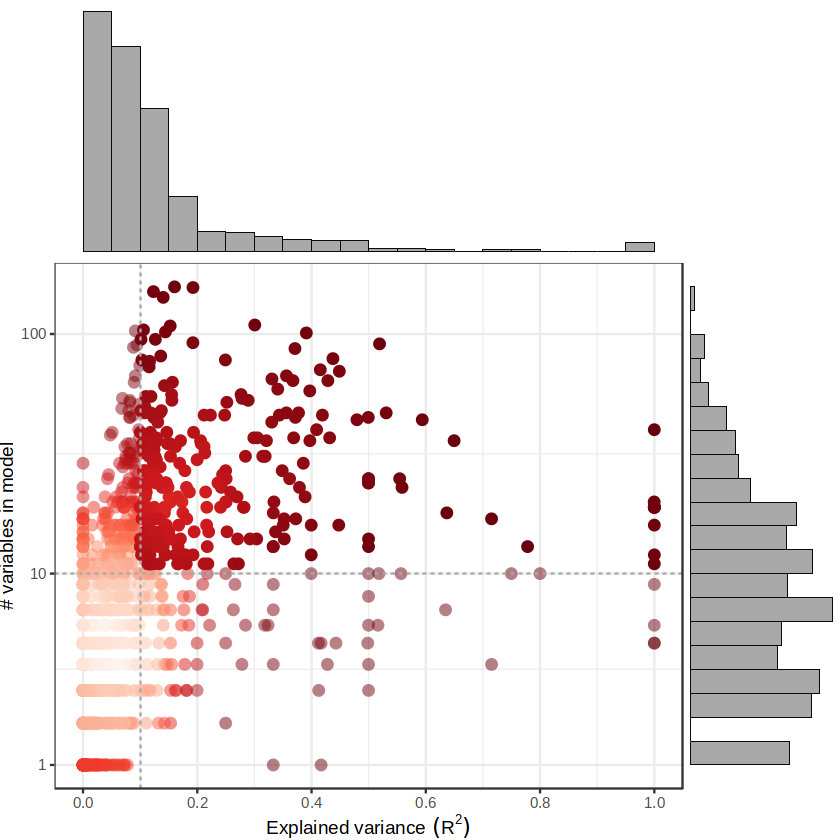

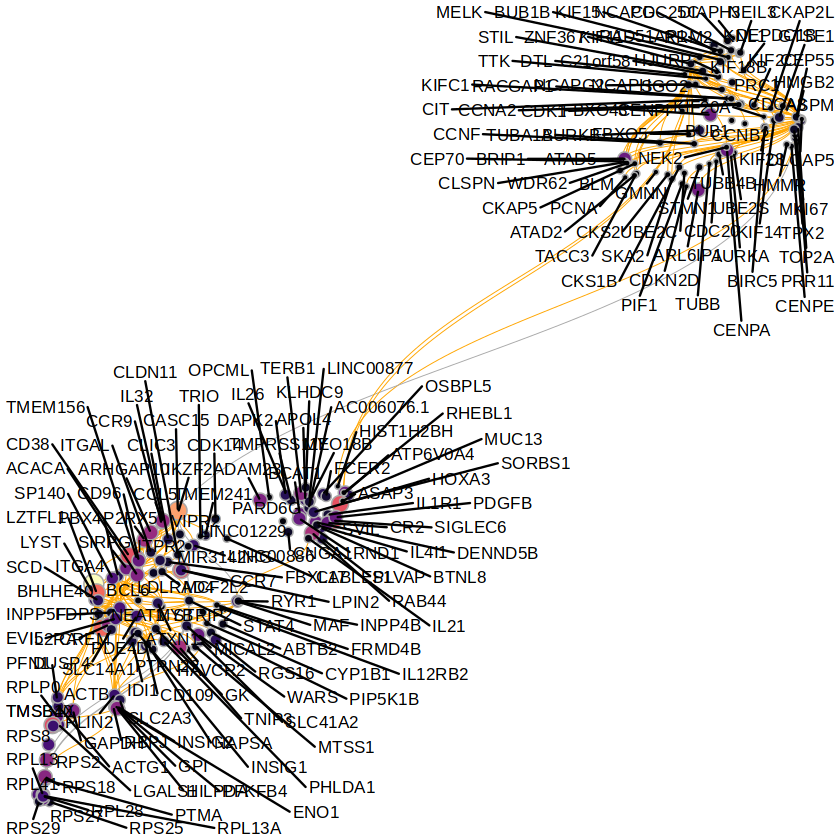

In [30]:
###plotting
p1 <- plot_gof(T_cells_naive, point_size=3)
T_cells_naive <- get_network_graph(T_cells_naive)
p2 <- plot_network_graph(T_cells_naive)

p1
p2

Warning message:
"Using alpha for a discrete variable is not advised."
Computing gene-gene correlation

Computing weighted regulatory factor

Computing UMAP embedding

Getting network graph



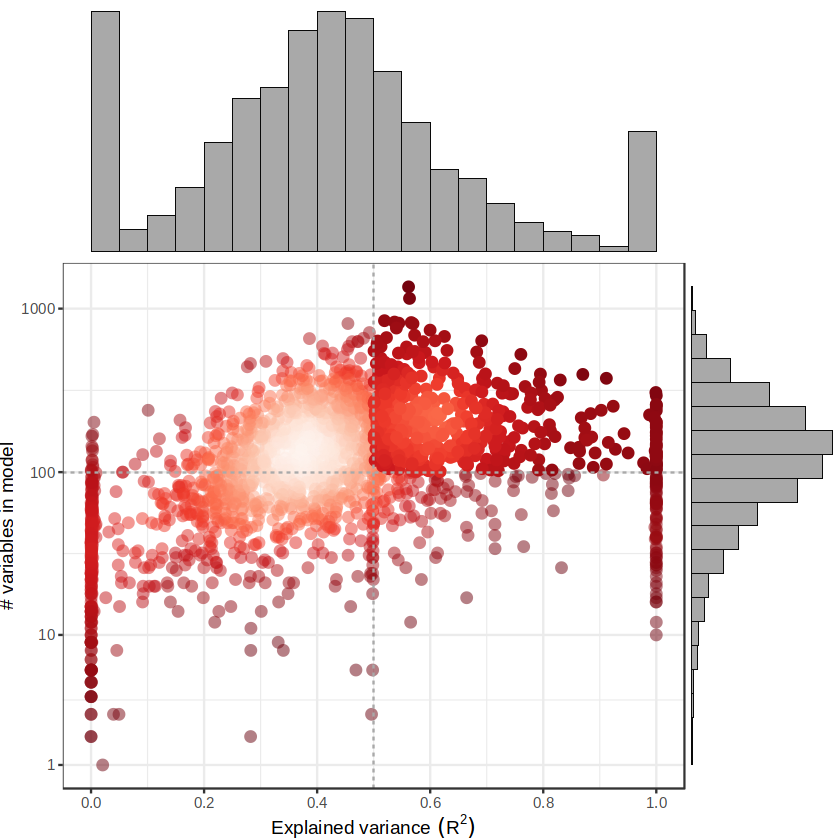

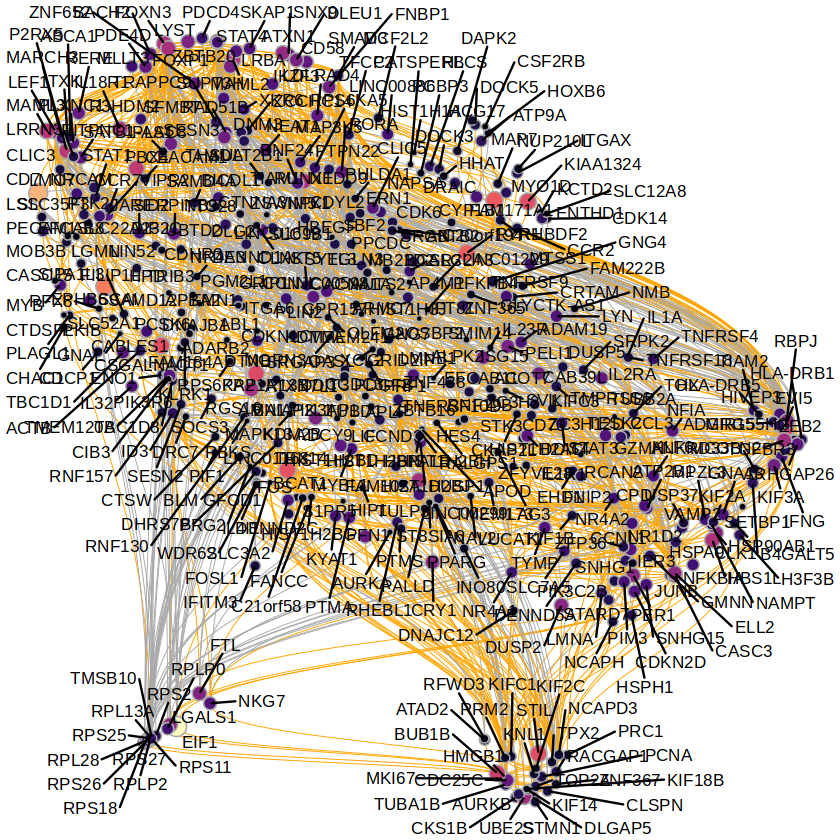

In [55]:
###plotting
p3 <- plot_gof(T_cells_Th1, point_size=3)
T_cells_Th1 <- get_network_graph(T_cells_Th1)
p4 <- plot_network_graph(T_cells_Th1)

p3
p4

In [35]:
# Here we get neither a ‘normal’ coefficient, nor a p-value, 
# but instead 3 different importance values: gain, cover, and frequency.
# These indicate the importance of the variable to the regressor. 
# To extract modules one can select the top target genes for each TF based on the gain value. 
# Alternatively, one can select the top TFs for each target gene.

Warning message:
"Using alpha for a discrete variable is not advised."
Computing gene-gene correlation

Computing weighted regulatory factor

Computing UMAP embedding

Getting network graph



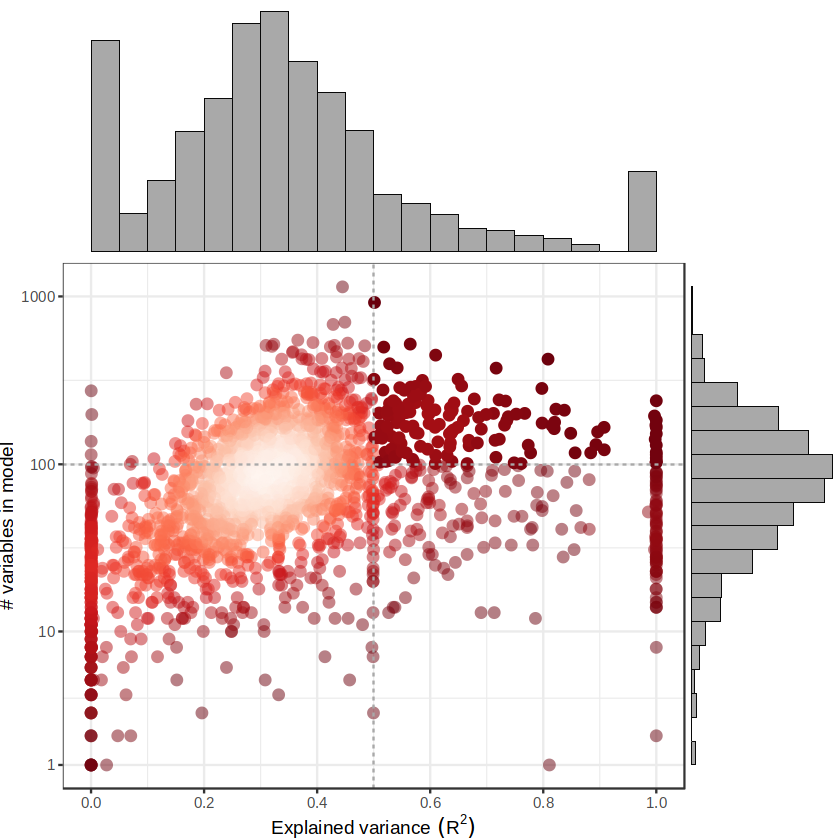

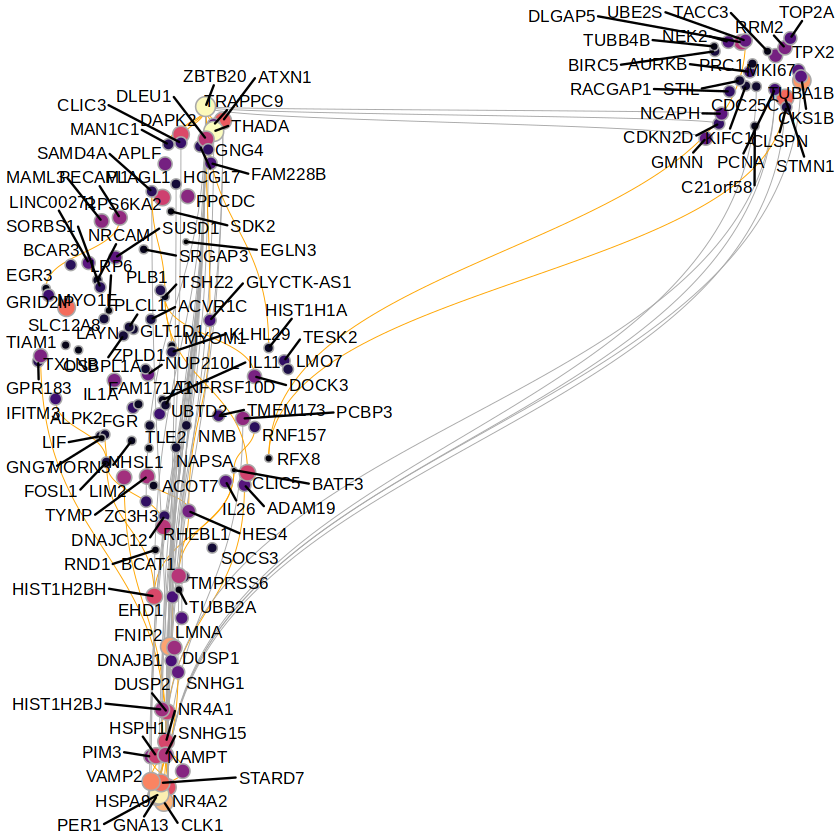

In [56]:
###plotting
p5 <- plot_gof(T_cells_NK, point_size=3)
T_cells_NK <- get_network_graph(T_cells_NK)
p6 <- plot_network_graph(T_cells_NK)

p5
p6